In [1]:
import numpy as np
import pandas as pd
from Jesse_Funcs_New.JessePlot import SpecificPlots
from Jesse_Funcs_New import blahut
import matplotlib.pyplot as plt

from __future__ import division
from pylab import *
from scipy import optimize


import Jesse_Funcs_New.JessePlot
# import Jesse_Funcs_New.blahut as blahut
import Jesse_Funcs_New.helpers as helpers
%matplotlib inline  

In [2]:
def mean_slice(cond_slice):
    x = np.arange(len(cond_slice))
    mean_slice = np.dot(x,cond_slice)
    return mean_slice

def varr_slice(cond_slice):
    x = np.arange(len(cond_slice))
    mean_slice = np.dot(x,cond_slice)
    shift_x_sq = (x - mean_slice)**2
    var_slice = np.dot(shift_x_sq,cond_slice)
    return var_slice

def normalizer(x,new_min,new_max):
    x_max = np.amax(x)
    x_min = np.amin(x)

    return (((x-x_min)/(x_max-x_min))*(new_max-new_min)+new_min)

def get_data(data_path, plot_data = False, new_data = True, device_num=0, take_log = True):
    data = pd.read_pickle(data_path)
    
    if new_data:
        device_idx = [data['Device'] == device_num]
        V_device = np.array(data['V'][device_idx[0]])
        R_device = np.array(data['R'][device_idx[0]])
    else: 
        V_device = np.array(data['V'])
        R_device = np.array(data['R'])
    if plot_data:
        plt.figure(figsize=(20,10))
        plt.scatter(V_device,np.log10(R_device), c='green')
        
    if take_log:
        R_device = np.log10(R_device)
    
    return V_device, R_device

def upsample_data(V, R, to_plot_or_not_to_plot = True, resample_rate = 1000):
    
    if to_plot_or_not_to_plot:
        plt.figure(figsize=(20,10))
        plt.xlim(V[0],V[len(V)-1])
        plt.scatter(V, R, c='green')

    P_RV, V_grid, R_grid = blahut.Q(V, R, nx=resample_rate, ny=resample_rate)
    
    flipped_P_RV = np.zeros_like(P_RV)
    for i in range(len(P_RV)):
        flipped_P_RV[:,i] = np.flip(P_RV[:,i],axis=0)
        
    if to_plot_or_not_to_plot:
        plt.figure(figsize=(20,20))
        plt.imshow(flipped_P_RV, origin='lower')
    
    return flipped_P_RV, V_grid, R_grid #algorithm for discrete cap wants grids, other plot funcs just want V, R

def varr_maker(P_RV, V, R, color = 'purple', plot_varrs = True):
    
    means = np.zeros_like(P_RV[0,:])
    for i in range(len(P_RV)):
        means[i] = mean_slice(P_RV[:,i])
        
    varr = np.zeros_like(P_RV[0,:])
    for i in range(len(P_RV)):
        varr[i] = varr_slice(P_RV[:,i])
    varr[varr < 0.0 ] = - varr[varr < 0.0 ]
    std = np.sqrt(varr)
    
    upper = means+std
    lower = means-std
    
    data_mean, data_std = blahut.moments(V, R)
    
    min_data_mean = np.amin(data_mean)
    min_data_mean_idx = np.where(data_mean == min_data_mean)
    min_data_std = data_std[min_data_mean_idx[0][0]]

    max_data_mean = np.amax(data_mean)
    max_data_mean_idx = np.where(data_mean == max_data_mean)
    max_data_std = data_std[max_data_mean_idx[0][-1]]
    
    upper_new_min = np.amin(data_mean)+min_data_std
    upper_new_max = np.amax(data_mean)+max_data_std
    lower_new_min = np.amin(data_mean)-min_data_std
    lower_new_max = np.amax(data_mean)-max_data_std
    
    upper_Rs = normalizer(upper,upper_new_min,upper_new_max)
    lower_Rs = normalizer(lower,lower_new_min,lower_new_max)
    means_Rs = normalizer(means,np.amin(data_mean),np.amax(data_mean))
    
    new_Vs = np.linspace(np.amin(V),np.amax(V), len(means_Rs))

    if plot_varrs:
        plt.figure(figsize=(20,10))

        plt.scatter(new_Vs, upper_Rs, marker='.', s=0.05, c= 'red')
        plt.scatter(np.linspace(np.amin(V),np.amax(V), len(data_mean)),data_mean+data_std, c = 'red', marker='_')

        plt.scatter(new_Vs, means_Rs, marker='.', s=0.05, c='blue')
        plt.scatter(np.linspace(np.amin(V),np.amax(V), len(data_mean)),data_mean, c = 'blue', marker='_')

        plt.scatter(new_Vs, lower_Rs, marker='.', s=0.05, c= 'red')
        plt.scatter(np.linspace(np.amin(V),np.amax(V), len(data_mean)),data_mean-data_std, c = 'red', marker='_')

        plt.figure(figsize=(20,10))
        plt.fill_between(new_Vs, lower_Rs, upper_Rs, alpha=0.5, color=color)
    
    return new_Vs, lower_Rs, upper_Rs

def super_channel(data_path, device_nums, diffs, colors, alphas):
    plt.figure(figsize=(20,10))
    V, R = get_data(data_path, plot_data = False, new_data = True, take_log = True, device_num = 0)
    R = R+diffs[0]
    for i in device_nums[1:]:
        V_new, R_new = get_data(data_path, plot_data = False, new_data = True, take_log = True, device_num = device_nums[i])
        V = np.append(V,V_new)
        R = np.append(R,R_new+diffs[i])
    plt.scatter(V,R)
    plt.savefig('super_channel.png')        
    
    plt.figure(figsize=(20,10))
    data_mean, data_std,_ = blahut.moments(V, R)    
    new_Vs = np.linspace(np.amin(V), np.amax(V),len(data_mean))
    lower_Rs = data_mean-data_std
    upper_Rs = data_mean+data_std
    plt.fill_between(new_Vs, lower_Rs, upper_Rs, alpha=alphas[i], color=colors[i])
    plt.xlabel(r'V', fontsize=18)
    plt.ylabel(r'$\log _{ 10 }{ \left( R \right)  }$ ', fontsize=18)
    plt.savefig('super_channel_varr.png')        

    return V, R 

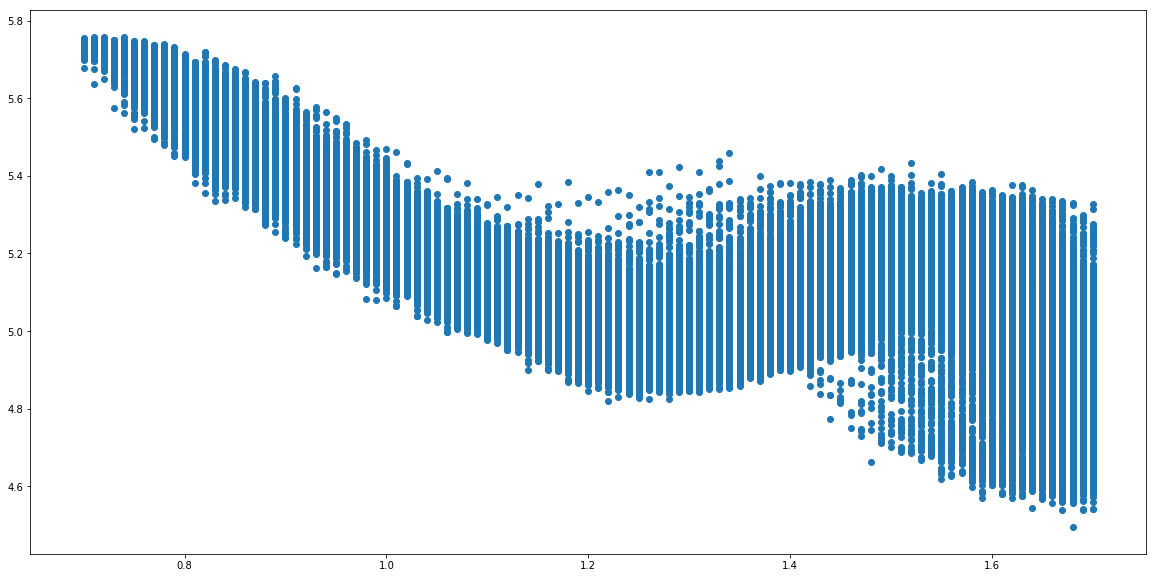

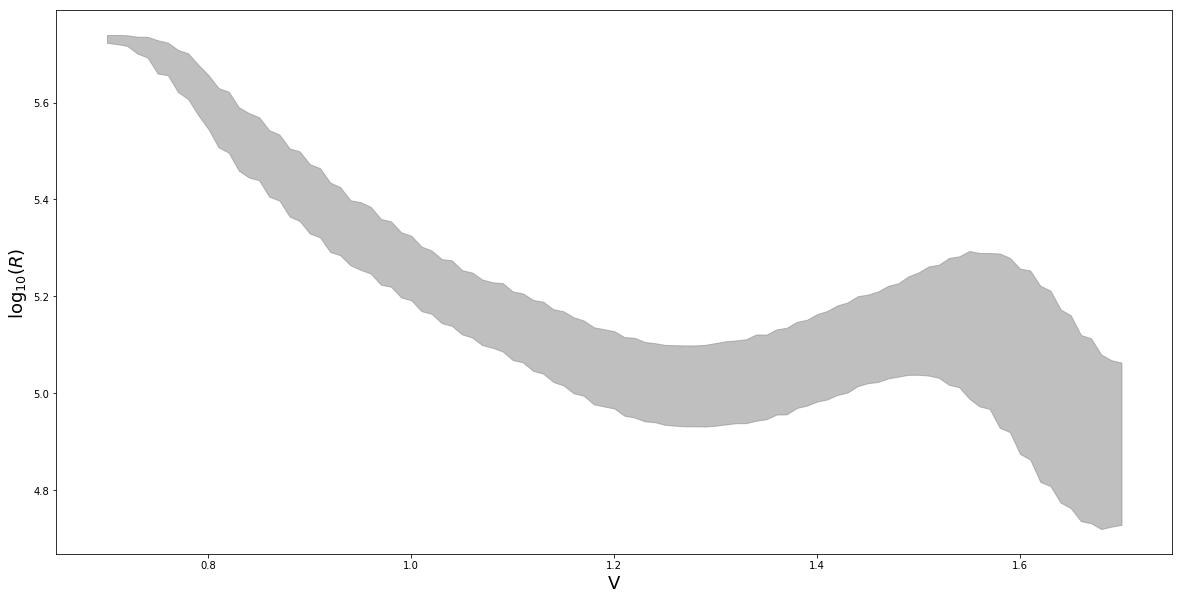

In [3]:
data_path = 'Data/PCM_20140605.pkl'
device_nums = np.arange(7)
diffs = np.array([0.32,0.4,0.12,0.115,0.235,0.0,0.26])
# diffs = np.zeros(7)
colors = ['red','orange','yellow','green','blue','purple','grey']
alphas = np.array([0.5]*7)


V_super, R_super = super_channel(data_path, device_nums, diffs, colors, alphas)

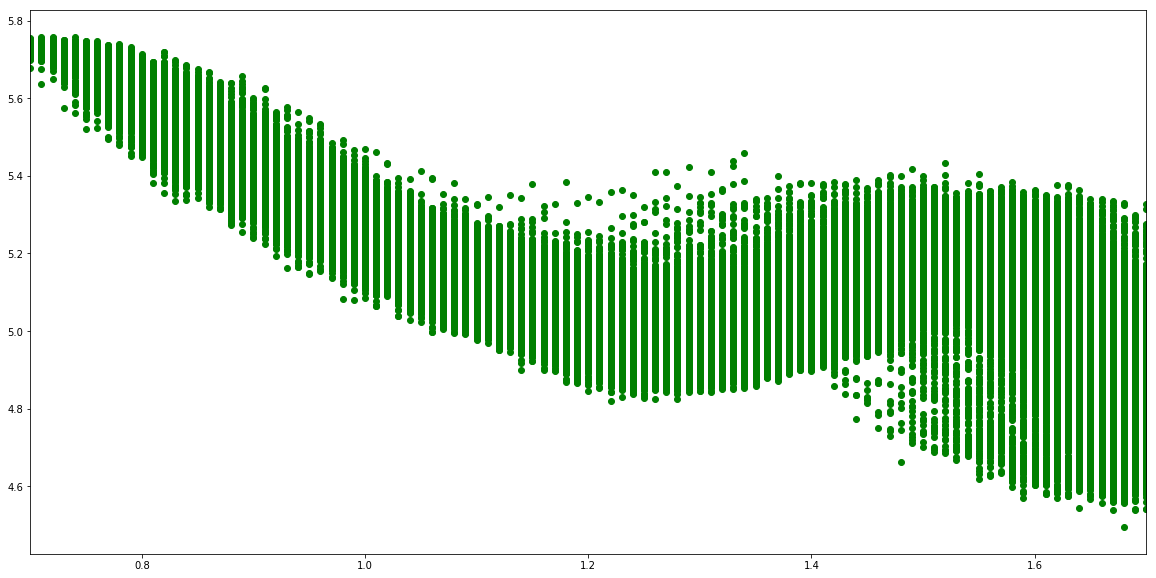

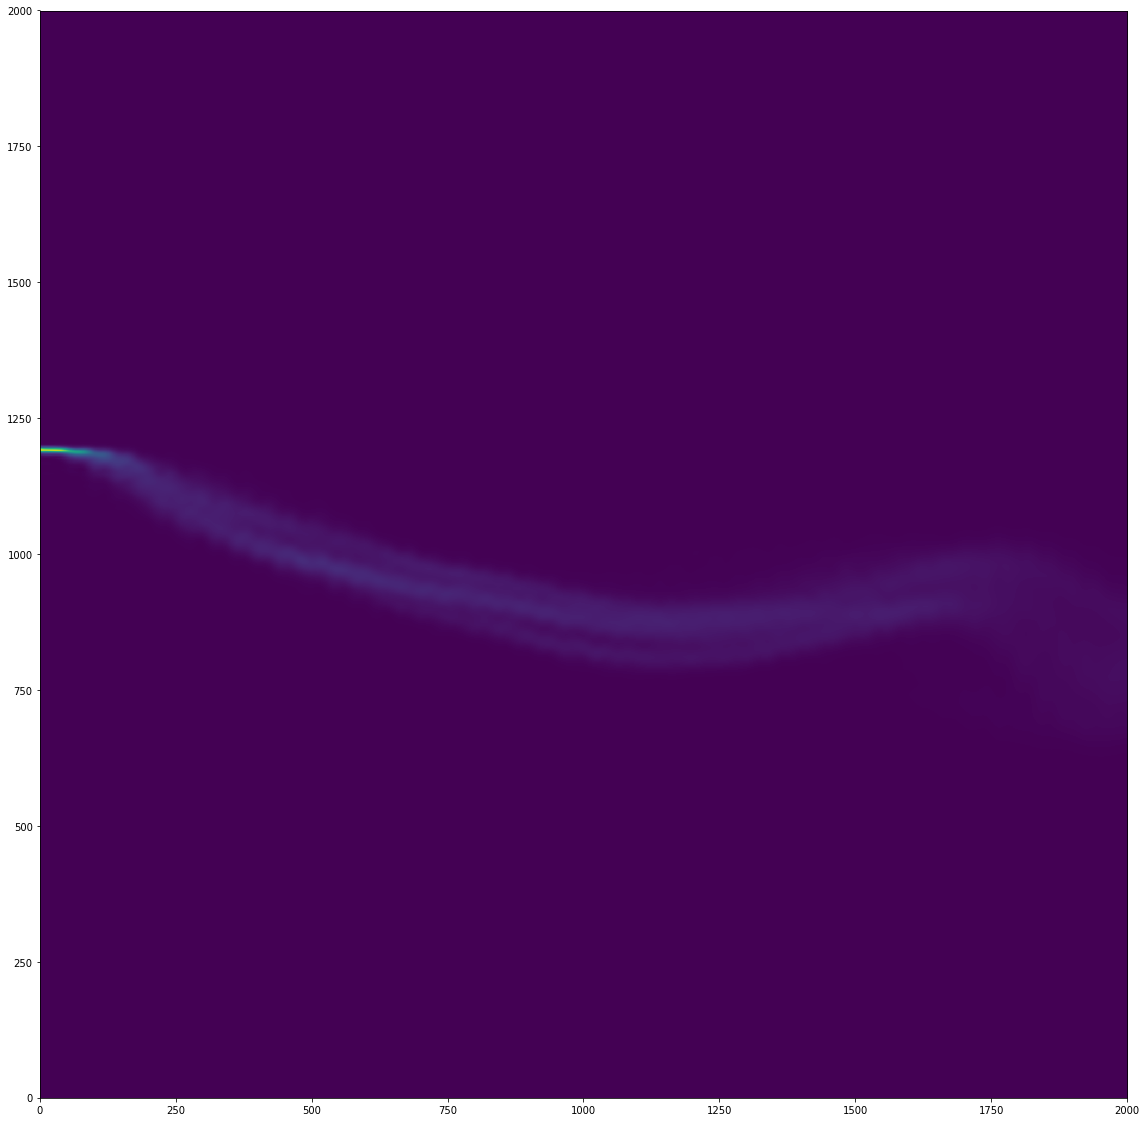

In [4]:
Pyx, x, y = upsample_data(V_super, R_super, to_plot_or_not_to_plot = True, resample_rate = 2000)

In [5]:
#==============================================================================
# %% Nonuniform Spacing
#==============================================================================
nonequal_filename = 'C_nonequal_optimized_new_PCM_more_states.npz'
new_run = False
nx = 6
ny = 6
nbits=5
# write_read_list = [(0,0),(0,1),(1,0),(1,1),(0,2),(2,0),(1,2),(2,1),(2,2),(0,3),(3,0),(1,3),(3,1),(2,3),(3,2),(3,3)]
# write_read_list = [(0,0),(0,1),(1,0),(1,1),(0,2),(2,0),(1,2),(2,1),(2,2)]
# write_read_list = [(0,3),(3,0),(1,3),(3,1),(2,3),(3,2),(3,3)]
# write_read_list = [(1,2),(1,3),(2,1)]
write_read_list = [(4,4)]

if new_run:
    C_nonequal = zeros((nbits, nbits))
else: 
    old_file = np.load(nonequal_filename)
    C_nonequal = old_file['data'].item()['C_nonequal'] 
    
x_in = [ [0 for i in range(nbits)] for j in range(nbits)]
y_out = [ [0 for i in range(nbits)] for j in range(nbits)]
Px_in = [ [0 for i in range(nbits)] for j in range(nbits)]

states = 2**(arange(nbits)+1)

xy = meshgrid(states, states)

xr = [min(x), (min(x) + max(x))/2, max(x)]
yr = [min(y), (min(y) + max(y))/2, max(y)]

In [6]:
def objective(val, Pyx=Pyx, x=x, y=y, nx=nx, ny=ny):
    global C_nonequal, x_in, y_out, Px_in
    
    xinputs = val[0:nx]
    ydividers = val[nx:]
    
    xinputs.sort()
    ydividers.sort()
        
    Pyx_sub, x_sub, y_sub = blahut.quantize(Pyx, x, y, xinputs, ydividers)
    
    C, Px = blahut.blahut_arimoto(Pyx_sub, 
                                  tolerance=1e-7, 
                                  iterations = 1000)
    
    if C > C_nonequal[ix, iy]:        
        C_nonequal[ix, iy] = C 
        x_in[ix][iy] = xinputs
        y_out[ix][iy] = ydividers
        Px_in[ix][iy] = Px

        data = dict(C_nonequal=C_nonequal,
                    x_in = x_in, 
                    y_out = y_out,
                    Px_in = Px_in)
        savez(nonequal_filename, data=data)    

    return -C

def accept_test(f_new, x_new, f_old, x_old):
    '''
    Make it so there aren't two dividers with the same value
    '''
    if len(x_new) == len(set(x_new)):
        return True
    else:
        return False

def find_peaks(Px):
    peak = logical_and( logical_and(Px > append(0, Px[:-1]), Px > append(Px[1:],0)), Px > 2e-4)
    return where(peak)

for it in range(1): 
    print (it)
    for ix, iy in write_read_list:
        ny, nx = (xy[0][ix,iy], xy[1][ix,iy])
    
        xinputs = rand(nx) * abs(xr[2]-xr[0]) + xr[0]
        ydividers = rand(ny-1) * abs(yr[2]-yr[0]) + yr[0]    
        xinputs = sort(xinputs)
        ydividers = sort(ydividers)          

        x0 = np.append(xinputs, ydividers)    
        params = (Pyx, x, y, nx, ny)
        bounds = [ (xr[0], xr[2]) for i in arange(nx) ]
        bounds.extend( [(yr[0], yr[2]) for i in arange(ny-1)] )
            
        minimizer_kwargs = dict(method='L-BFGS-B',
                                args=params,
                                bounds=bounds)
    
        result = optimize.basinhopping(objective, 
                                       x0=x0, 
                                       minimizer_kwargs=minimizer_kwargs,
                                       niter=50, #used to be 50, then 100, then 200, then 300
                                       stepsize=0.3, #used to be 0.5 #then was 0.1, 0.2 #maybe try back to 0.2?
                                       T=0.5,
                                       accept_test=accept_test)
        
        print (result)
               
data = dict(C_nonequal=C_nonequal,
            x_in = x_in, 
            y_out = y_out,
            Px_in = Px_in)
savez(nonequal_filename, data=data)  

0


/home/rzarcone/PCM_Paper/Jesse_Funcs_New/blahut.py:62: RuntimeWarning: divide by zero encountered in log2
  d = p * np.log2(p / np.r_[q])
/home/rzarcone/PCM_Paper/Jesse_Funcs_New/blahut.py:62: RuntimeWarning: invalid value encountered in log2
  d = p * np.log2(p / np.r_[q])
/home/rzarcone/PCM_Paper/Jesse_Funcs_New/blahut.py:62: RuntimeWarning: invalid value encountered in multiply
  d = p * np.log2(p / np.r_[q])
/home/rzarcone/PCM_Paper/Jesse_Funcs_New/blahut.py:62: RuntimeWarning: invalid value encountered in true_divide
  d = p * np.log2(p / np.r_[q])
/home/rzarcone/PCM_Paper/Jesse_Funcs_New/blahut.py:62: RuntimeWarning: divide by zero encountered in true_divide
  d = p * np.log2(p / np.r_[q])


                        fun: -1.5960597925746911
 lowest_optimization_result:       fun: -1.5960597925746911
 hess_inv: <63x63 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 64
      nit: 0
   status: 0
  success: True
        x: array([ 0.7       ,  0.75894218,  0.77322463,  0.78376707,  0.90573456,
        0.92292404,  0.94341846,  0.97749307,  1.02521348,  1.03383263,
        1.09306196,  1.20520039,  1.21057915,  1.2120293 ,  1.21318575,
        1.2477289 ,  1.30125729,  1.30214217,  1.30383122,  1.36168612,
        1.42144208,  1.44669412,  1.4692282 ,  1.5089

In [11]:
data_file = np.load(nonequal_filename)
test_mat_new = data_file['data'].item()['C_nonequal']
np.round(test_mat_new, 2)

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  1.94]])

In [12]:
data_file = np.load('C_nonequal_optimized_new_PCM.npz')
test_mat = data_file['data'].item()['C_nonequal']
np.round(test_mat, 2)

array([[ 1.  ,  1.  ,  1.  ,  1.  ],
       [ 1.  ,  1.56,  1.7 ,  1.77],
       [ 1.  ,  1.66,  1.82,  1.88],
       [ 1.  ,  1.81,  1.9 ,  1.93]])

In [13]:
combined_mat_idx = [test_mat>0.0]
test_mat_new[combined_mat_idx] = test_mat[combined_mat_idx]

/home/rzarcone/tensorflow/lib/python3.4/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5 but corresponding boolean dimension is 4
  


In [14]:
np.round(test_mat_new, 2)

array([[ 1.  ,  1.  ,  1.  ,  1.  ,  0.  ],
       [ 1.  ,  1.56,  1.7 ,  1.77,  0.  ],
       [ 1.  ,  1.66,  1.82,  1.88,  0.  ],
       [ 1.  ,  1.81,  1.9 ,  1.93,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  1.94]])